In [2]:
#Tweaking dari Pai :D

import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
# from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [3]:
SHAPE = 256
SPLIT_SIZE = 0.9

## defining a frame for image and mask storage
framObj = {'img' : [],
           'mask' : []
          }

framObjTrain = {'img' : [],
           'mask' : []
          }

framObjValidation = {'img' : [],
           'mask' : []
          }

In [4]:
## defining data Loader function
def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = SHAPE): ### !!! SPLIT DATASET
    imgNames = os.listdir(imgPath)
    maskNames = []
    
    ## generating mask names
    for mem in imgNames:
        maskNames.append(re.sub('\.jpg', '.png', mem))
    
    ## defining images and labels path
    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'
    
    ## loop all images
    for i in range (len(imgNames)):
        try:
            ## read an image and the corresponding label
            img = plt.imread(imgAddr + imgNames[i])
            mask = plt.imread(maskAddr + maskNames[i])
            
            ## normalize image color
            img = img/255.0
            
            ## resize image dimension to SHAPE x SHAPE
            img = cv2.resize(img, (shape, shape))
            mask = cv2.resize(mask, (shape, shape))
        except:
            continue
    
        frameObj['img'].append(img)
        frameObj['mask'].append(mask)
        
    return frameObj

In [5]:
## defining data Split function
def split_data(SOURCE, TRAINING, VALIDATION, SPLIT_SIZE):
    i = 0
    # split
    train_size = int(len(SOURCE['mask']) * SPLIT_SIZE)

    for img in SOURCE['img']:
        if i <= train_size:
            TRAINING['img'].append(img)
        else: 
            # Switch copy target to TESTING
            VALIDATION['img'].append(img)
        i += 1

    i = 0
    for mask in SOURCE['mask']:
        if i <= train_size:
            TRAINING['mask'].append(mask)
        else: 
            # Switch copy target to TESTING
            VALIDATION['mask'].append(mask)
        i += 1

    return TRAINING, VALIDATION

In [6]:
framObj = LoadData(framObj, ### !!! IMPLEMENT CHANGED METHOD
                    imgPath = 'dataset/images', 
                    maskPath = 'dataset/labels_only_clothing',
                    shape = SHAPE)

# print(len(framObj['img']))

In [7]:
framObjTrain, framObjValidation = split_data(SOURCE = framObj, 
                                            TRAINING = framObjTrain, 
                                            VALIDATION = framObjValidation, 
                                            SPLIT_SIZE = SPLIT_SIZE)

# print(len(framObjTrain['img']))
# print(len(framObjTrain['mask']))

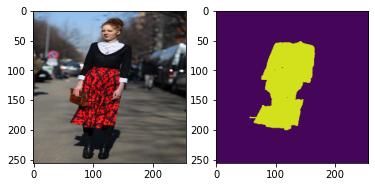

In [8]:
## displaying data loaded by our function
import random
n = random.randint(0,100)

plt.subplot(1,2,1)
plt.imshow(framObjTrain['img'][n])
plt.subplot(1,2,2)
plt.imshow(framObjTrain['mask'][n])
plt.show()

In [9]:
model_1 = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(256, 256, 3)),

        # Encoder
        tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation="relu", padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation="relu", padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation="relu", padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding='same'),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding='same'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding='same'),
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation="relu", padding='same'),

        # Decoder
        tf.keras.layers.UpSampling2D(size=(2, 2)),
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation="relu", padding='same'),
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding='same'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding='same'),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding='same'),

        tf.keras.layers.UpSampling2D(size=(2, 2)),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding='same'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding='same'),
        tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation="relu", padding='same'),

        tf.keras.layers.UpSampling2D(size=(2, 2)),
        tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same'),

        tf.keras.layers.UpSampling2D(size=(2, 2)),
        tf.keras.layers.Conv2D(filters=3, kernel_size=(3, 3), activation='relu', padding='same')

    ])

In [10]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 16)        2320      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 16)       0

In [11]:
model_1.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 5e-5), ### !!! TRY DIFFERENT ALGORITHM
    loss = 'mean_absolute_error', ### !!! TRY DIFFERENT ALGORITHM
    metrics = ['acc'])

In [12]:
#Training Data
retVal = model_1.fit(np.array(framObjTrain['img']),
                           np.array(framObjTrain['mask']),
                           batch_size=32, ### !!! TRY DIFFERENT BATCH SIZE
                           ### !!! ADD VALIDATION DATASET
                           epochs = 100, ### !!! CHANGE BACK TO 100
                           validation_data=(np.array(framObjValidation['img']), np.array(framObjValidation['mask']))
                           )

Epoch 1/100
29/29 [==============================] - 18s 257ms/step - loss: 0.2606 - acc: 0.0896 - val_loss: 0.2286 - val_acc: 0.0069
Epoch 2/100
29/29 [==============================] - 5s 157ms/step - loss: 0.2125 - acc: 0.0187 - val_loss: 0.1512 - val_acc: 0.0579
Epoch 3/100
29/29 [==============================] - 5s 162ms/step - loss: 0.1496 - acc: 0.4180 - val_loss: 0.1363 - val_acc: 0.7584
Epoch 4/100
29/29 [==============================] - 5s 172ms/step - loss: 0.1289 - acc: 0.6395 - val_loss: 0.1300 - val_acc: 0.7837
Epoch 5/100
29/29 [==============================] - 5s 160ms/step - loss: 0.1197 - acc: 0.7397 - val_loss: 0.1278 - val_acc: 0.7983
Epoch 6/100
29/29 [==============================] - 5s 164ms/step - loss: 0.1142 - acc: 0.7873 - val_loss: 0.1214 - val_acc: 0.8096
Epoch 7/100
29/29 [==============================] - 5s 168ms/step - loss: 0.1109 - acc: 0.8054 - val_loss: 0.1194 - val_acc: 0.8132
Epoch 8/100
29/29 [==============================] - 5s 188ms/step -

29/29 [==============================] - 6s 191ms/step - loss: 0.0401 - acc: 0.9202 - val_loss: 0.0415 - val_acc: 0.9209
Epoch 63/100
29/29 [==============================] - 6s 197ms/step - loss: 0.0399 - acc: 0.9210 - val_loss: 0.0412 - val_acc: 0.9193
Epoch 64/100
29/29 [==============================] - 6s 196ms/step - loss: 0.0396 - acc: 0.9213 - val_loss: 0.0413 - val_acc: 0.9201
Epoch 65/100
29/29 [==============================] - 6s 200ms/step - loss: 0.0393 - acc: 0.9219 - val_loss: 0.0438 - val_acc: 0.9113
Epoch 66/100
29/29 [==============================] - 6s 193ms/step - loss: 0.0396 - acc: 0.9218 - val_loss: 0.0405 - val_acc: 0.9197
Epoch 67/100
29/29 [==============================] - 6s 206ms/step - loss: 0.0388 - acc: 0.9229 - val_loss: 0.0403 - val_acc: 0.9202
Epoch 68/100
29/29 [==============================] - 6s 200ms/step - loss: 0.0388 - acc: 0.9231 - val_loss: 0.0404 - val_acc: 0.9219
Epoch 69/100
29/29 [==============================] - 6s 205ms/step - loss:

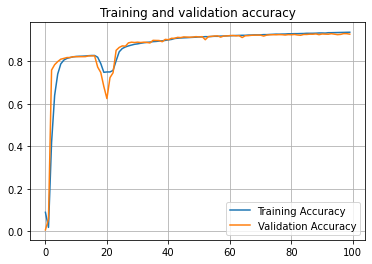

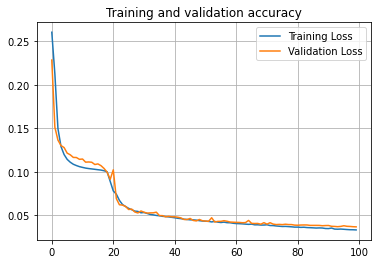

In [13]:
acc = retVal.history['acc']
val_acc = retVal.history['val_acc']
loss = retVal.history['loss']
val_loss = retVal.history['val_loss']

epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = 'Training Accuracy')
plt.plot(epochs, val_acc, label = 'Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = 'Training Loss')
plt.plot(epochs, val_loss, label = 'Validation Loss')
plt.title('Training and validation accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
def predict16 (valMap, model, shape = SHAPE):
    ## getting and proccessing val data
    img = valMap['img']
    mask = valMap['mask']
    mask = mask[0:25]
    
    imgProc = img [0:25]
    imgProc = np.array(img)
    
    predictions = model.predict(imgProc)
    for i in range(len(predictions)):
        predictions[i] = cv2.merge((predictions[i,:,:,0],predictions[i,:,:,1],predictions[i,:,:,2]))
    
    return predictions, imgProc, mask


def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(7,7))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('image')
    
    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted Mask')
    
    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('actual Mask')

In [15]:
sixteenPrediction, actuals, masks = predict16(framObjTrain, model_1)

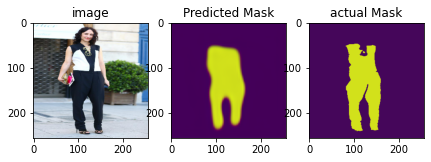

In [16]:
n_r = random.randint(0,15)
n_r = 18
Plotter(actuals[n_r], sixteenPrediction[n_r], masks[n_r])

In [17]:
#plt.imshow(actuals[n_r])
#plt.savefig('result_img/img.png')

In [18]:
#plt.imshow(sixteenPrediction[n_r])
#plt.savefig('result_img/mask.png')

In [19]:
save_file = 'save_model/model_004.h5'
model_1.save_weights(save_file)